# Task 1

## Intro

### Deps and Imports

In [2]:
:dep polars = { version = "0.35.4", features = ["lazy", "mode", "to_dummies", "describe"] }
:dep plotters = { version = "0.3.5", features = ["evcxr"] }

In [3]:
use std::{collections::HashMap, fmt::Display, ops::Index};

use plotters::prelude::*;
use polars::prelude::*;

std::env::set_var("POLARS_FMT_MAX_ROWS", "10");

### Meet the Database
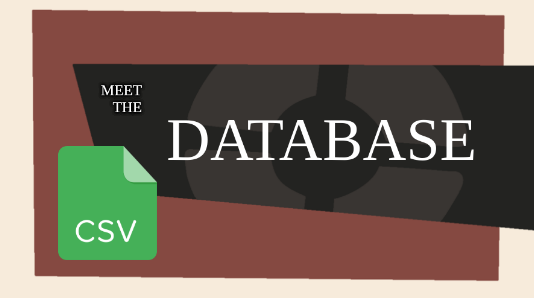

We get a dataset. The chosen dataset is from Kaggle:
Global Video Game Sales.
*Analyzing Platform-Genre Dynamics in the Top 100 Games*

**URL:** `https://doi.org/10.5281/zenodo.5898311`

with the following schema:

- Rank - Ranking of overall sales
- Name - The games name
- Platform - Platform of the games release (i.e. PC,PS4, etc.)
- Year - Year of the game's release
- Genre - Genre of the game
- Publisher - Publisher of the game
- NA_Sales - Sales in North America (in millions)
- EU_Sales - Sales in Europe (in millions)
- JP_Sales - Sales in Japan (in millions)
- Other_Sales - Sales in the rest of the world (in millions)
- Global_Sales - Total worldwide sales. (in millions)

Given the information of our database, we can generate a useful struct for our data.

In [4]:
#[derive(Debug, Clone)]
enum Columns {
    RANK,
    NAME,
    PLATFORM,
    YEAR,
    GENRE,
    PUBLISHER,
    NA_SALES,
    EU_SALES,
    JP_SALES,
    OTHER_SALES,
    GLOBAL_SALES,
}

And we implement useful methods.

In [5]:
impl Columns {
    fn sales_columns() -> Vec<Self> {
        vec![
            Self::NA_SALES,
            Self::EU_SALES,
            Self::JP_SALES,
            Self::OTHER_SALES,
            Self::GLOBAL_SALES,
        ]
    }

    fn as_expr(&self) -> Expr {
        col(self.as_ref())
    }
}

impl AsRef<str> for Columns {
    fn as_ref(&self) -> &str {
        match self {
            Self::RANK => "Rank",
            Self::NAME => "Name",
            Self::PLATFORM => "Platform",
            Self::YEAR => "Year",
            Self::GENRE => "Genre",
            Self::PUBLISHER => "Publisher",
            Self::NA_SALES => "NA_Sales",
            Self::EU_SALES => "EU_Sales",
            Self::JP_SALES => "JP_Sales",
            Self::OTHER_SALES => "Other_Sales",
            Self::GLOBAL_SALES => "Global_Sales",
        }
    }
}

impl Display for Columns {
    fn fmt(&self, f: &mut std::fmt::Formatter<'_>) -> std::fmt::Result {
        write!(f, "{}", self.as_ref())
    }
}

impl Index<Columns> for DataFrame {
    type Output = Series;

    fn index(&self, index: Columns) -> &Self::Output {
        &self[index.as_ref()]
    }
}

impl Into<Expr> for Columns {
    fn into(self) -> Expr {
        self.as_expr()
    }
}

We read the CSV file containing our data.

In [6]:
let csv_path = "vgsales.csv";
let mut df = CsvReader::from_path(csv_path)?
    .has_header(true)
    .with_null_values(Some(NullValues::AllColumnsSingle("N/A".into())))
    .finish()?;
df

shape: (16_598, 11)
┌───────┬─────────────────┬──────────┬──────┬───┬──────────┬──────────┬─────────────┬──────────────┐
│ Rank  ┆ Name            ┆ Platform ┆ Year ┆ … ┆ EU_Sales ┆ JP_Sales ┆ Other_Sales ┆ Global_Sales │
│ ---   ┆ ---             ┆ ---      ┆ ---  ┆   ┆ ---      ┆ ---      ┆ ---         ┆ ---          │
│ i64   ┆ str             ┆ str      ┆ i64  ┆   ┆ f64      ┆ f64      ┆ f64         ┆ f64          │
╞═══════╪═════════════════╪══════════╪══════╪═══╪══════════╪══════════╪═════════════╪══════════════╡
│ 1     ┆ Wii Sports      ┆ Wii      ┆ 2006 ┆ … ┆ 29.02    ┆ 3.77     ┆ 8.46        ┆ 82.74        │
│ 2     ┆ Super Mario     ┆ NES      ┆ 1985 ┆ … ┆ 3.58     ┆ 6.81     ┆ 0.77        ┆ 40.24        │
│       ┆ Bros.           ┆          ┆      ┆   ┆          ┆          ┆             ┆              │
│ 3     ┆ Mario Kart Wii  ┆ Wii      ┆ 2008 ┆ … ┆ 12.88    ┆ 3.79     ┆ 3.31        ┆ 35.82        │
│ 4     ┆ Wii Sports      ┆ Wii      ┆ 2009 ┆ … ┆ 11.01    ┆ 3.28     ┆

To focus our data analysis we'll only choose the global sales column along with the rest of the data for the games listed.

In [7]:
df = df.drop_many(&[Columns::NA_SALES, Columns::EU_SALES, Columns::JP_SALES, Columns::OTHER_SALES]);
df

shape: (16_598, 7)
┌───────┬─────────────────────────────┬──────────┬──────┬──────────────┬────────────┬──────────────┐
│ Rank  ┆ Name                        ┆ Platform ┆ Year ┆ Genre        ┆ Publisher  ┆ Global_Sales │
│ ---   ┆ ---                         ┆ ---      ┆ ---  ┆ ---          ┆ ---        ┆ ---          │
│ i64   ┆ str                         ┆ str      ┆ i64  ┆ str          ┆ str        ┆ f64          │
╞═══════╪═════════════════════════════╪══════════╪══════╪══════════════╪════════════╪══════════════╡
│ 1     ┆ Wii Sports                  ┆ Wii      ┆ 2006 ┆ Sports       ┆ Nintendo   ┆ 82.74        │
│ 2     ┆ Super Mario Bros.           ┆ NES      ┆ 1985 ┆ Platform     ┆ Nintendo   ┆ 40.24        │
│ 3     ┆ Mario Kart Wii              ┆ Wii      ┆ 2008 ┆ Racing       ┆ Nintendo   ┆ 35.82        │
│ 4     ┆ Wii Sports Resort           ┆ Wii      ┆ 2009 ┆ Sports       ┆ Nintendo   ┆ 33.0         │
│ 5     ┆ Pokemon Red/Pokemon Blue    ┆ GB       ┆ 1996 ┆ Role-Playing ┆

## Size and Statistical measures

### Size

In [8]:
df.shape()

(16598, 7)

### Statistical measures

#### Mean, Std, Var, Median, Quantiles
In this example, quartiles were used.

In [9]:
df.describe(Some(&[0.25, 0.5, 0.75, 1.0]))?

shape: (10, 8)
┌────────────┬────────────┬────────────┬──────────┬────────────┬──────────┬────────────┬───────────┐
│ describe   ┆ Rank       ┆ Name       ┆ Platform ┆ Year       ┆ Genre    ┆ Publisher  ┆ Global_Sa │
│ ---        ┆ ---        ┆ ---        ┆ ---      ┆ ---        ┆ ---      ┆ ---        ┆ les       │
│ str        ┆ f64        ┆ str        ┆ str      ┆ f64        ┆ str      ┆ str        ┆ ---       │
│            ┆            ┆            ┆          ┆            ┆          ┆            ┆ f64       │
╞════════════╪════════════╪════════════╪══════════╪════════════╪══════════╪════════════╪═══════════╡
│ count      ┆ 16598.0    ┆ 16598      ┆ 16598    ┆ 16598.0    ┆ 16598    ┆ 16598      ┆ 16598.0   │
│ null_count ┆ 0.0        ┆ 0          ┆ 0        ┆ 271.0      ┆ 0        ┆ 58         ┆ 0.0       │
│ mean       ┆ 8300.60525 ┆ null       ┆ null     ┆ 2006.40644 ┆ null     ┆ null       ┆ 0.537441  │
│            ┆ 4          ┆            ┆          ┆ 3          ┆          ┆ 

#### Count of elements
Since it's already known the number of rows, an example is shown of counting rows by some condition. So let's count the number of games by platform in this database.

In [10]:
df.group_by([Columns::PLATFORM])?.count()?

shape: (31, 7)
┌──────────┬────────────┬────────────┬────────────┬─────────────┬─────────────────┬────────────────┐
│ Platform ┆ Rank_count ┆ Name_count ┆ Year_count ┆ Genre_count ┆ Publisher_count ┆ Global_Sales_c │
│ ---      ┆ ---        ┆ ---        ┆ ---        ┆ ---         ┆ ---             ┆ ount           │
│ str      ┆ u32        ┆ u32        ┆ u32        ┆ u32         ┆ u32             ┆ ---            │
│          ┆            ┆            ┆            ┆             ┆                 ┆ u32            │
╞══════════╪════════════╪════════════╪════════════╪═════════════╪═════════════════╪════════════════╡
│ TG16     ┆ 2          ┆ 2          ┆ 2          ┆ 2           ┆ 2               ┆ 2              │
│ PC       ┆ 960        ┆ 960        ┆ 960        ┆ 960         ┆ 960             ┆ 960            │
│ GB       ┆ 98         ┆ 98         ┆ 98         ┆ 98          ┆ 98              ┆ 98             │
│ 3DO      ┆ 3          ┆ 3          ┆ 3          ┆ 3           ┆ 3         

#### Unique elements
Now let's select the games with a unique release, meaning they were released for 1 console only.

In [11]:
df
    .clone()
    .lazy()
    .unique(
        Some(vec![Columns::NAME.to_string()]),
        UniqueKeepStrategy::Any,
    )
    .collect()?

shape: (11_493, 7)
┌───────┬──────────────────────┬──────────┬──────┬────────────┬─────────────────────┬──────────────┐
│ Rank  ┆ Name                 ┆ Platform ┆ Year ┆ Genre      ┆ Publisher           ┆ Global_Sales │
│ ---   ┆ ---                  ┆ ---      ┆ ---  ┆ ---        ┆ ---                 ┆ ---          │
│ i64   ┆ str                  ┆ str      ┆ i64  ┆ str        ┆ str                 ┆ f64          │
╞═══════╪══════════════════════╪══════════╪══════╪════════════╪═════════════════════╪══════════════╡
│ 1462  ┆ Donkey Kong Jungle   ┆ GC       ┆ 2004 ┆ Platform   ┆ Nintendo            ┆ 1.34         │
│       ┆ Beat                 ┆          ┆      ┆            ┆                     ┆              │
│ 1810  ┆ WWE 2K15             ┆ PS4      ┆ 2014 ┆ Sports     ┆ Take-Two            ┆ 1.13         │
│       ┆                      ┆          ┆      ┆            ┆ Interactive         ┆              │
│ 2493  ┆ The Game of Life     ┆ PS       ┆ 1998 ┆ Misc       ┆ Unknown 

#### Mode
Here we'll get the game with most releases.

In [12]:
mode::mode(&df[Columns::NAME])?

shape: (1,)
Series: 'Name' [str]
[
	"Need for Speed…
]

## Null-handling
We first verify the columns where we have more than zero missing values.
And we collect the names of the columns with null values.

In [13]:
df
    .iter()
    .filter_map(|col| {
        if col.null_count() > 0 {
            Some(col.name())
        } else {
            None
        }
    })
    .collect::<Vec<&str>>()

["Year", "Publisher"]

We'll replace the missing years with the average year by console, and remove the games with missing publishers.

Now we make a dataframe with the year average grouped by the platform.

In [14]:
let avg_yr_by_platform = df
    .clone()
    .lazy()
    .group_by([Columns::PLATFORM])
    .agg([Columns::YEAR.as_expr().mean().alias("Year_Mean")])
    .collect()?;

avg_yr_by_platform

shape: (31, 2)
┌──────────┬─────────────┐
│ Platform ┆ Year_Mean   │
│ ---      ┆ ---         │
│ str      ┆ f64         │
╞══════════╪═════════════╡
│ NES      ┆ 1987.153061 │
│ GB       ┆ 1995.958763 │
│ PS4      ┆ 2015.005952 │
│ DS       ┆ 2008.201125 │
│ WS       ┆ 2000.0      │
│ …        ┆ …           │
│ 3DS      ┆ 2013.062    │
│ PC       ┆ 2008.773065 │
│ GBA      ┆ 2003.210851 │
│ WiiU     ┆ 2013.594406 │
│ SCD      ┆ 1993.833333 │
└──────────┴─────────────┘

Now we join both dataframes to have the "Year_Mean" data based on their platform.

In [15]:
let df_with_year_avg = df
    .clone()
    .lazy()
    .join(
        avg_yr_by_platform.lazy(),
        [Columns::PLATFORM.as_expr()],
        [Columns::PLATFORM.as_expr()],
        JoinArgs::new(JoinType::Left),
    )
    .collect()?;

df_with_year_avg

shape: (16_598, 8)
┌───────┬───────────────┬──────────┬──────┬──────────────┬────────────┬──────────────┬─────────────┐
│ Rank  ┆ Name          ┆ Platform ┆ Year ┆ Genre        ┆ Publisher  ┆ Global_Sales ┆ Year_Mean   │
│ ---   ┆ ---           ┆ ---      ┆ ---  ┆ ---          ┆ ---        ┆ ---          ┆ ---         │
│ i64   ┆ str           ┆ str      ┆ i64  ┆ str          ┆ str        ┆ f64          ┆ f64         │
╞═══════╪═══════════════╪══════════╪══════╪══════════════╪════════════╪══════════════╪═════════════╡
│ 1     ┆ Wii Sports    ┆ Wii      ┆ 2006 ┆ Sports       ┆ Nintendo   ┆ 82.74        ┆ 2008.962791 │
│ 2     ┆ Super Mario   ┆ NES      ┆ 1985 ┆ Platform     ┆ Nintendo   ┆ 40.24        ┆ 1987.153061 │
│       ┆ Bros.         ┆          ┆      ┆              ┆            ┆              ┆             │
│ 3     ┆ Mario Kart    ┆ Wii      ┆ 2008 ┆ Racing       ┆ Nintendo   ┆ 35.82        ┆ 2008.962791 │
│       ┆ Wii           ┆          ┆      ┆              ┆            ┆ 

Since we have both year and average year by platform, we can replace null values of the year column with the respective average.

In [16]:
df.apply(Columns::YEAR.as_ref(), |col| {
    col.i64()
        .unwrap()
        .into_iter()
        .enumerate()
        .map(|(row, year)| {
            Some(
                year.unwrap_or(
                    df_with_year_avg["Year_Mean"]
                        .f64()
                        .unwrap()
                        .get(row)
                        .unwrap()
                        .floor() as i64,

                ),
            )
        })
        .collect::<Int64Chunked>()
        .into_series()
})?;

We check if there are any null entries left in the year column.

In [17]:
df
    .iter()
    .filter_map(|col| {
        if col.null_count() > 0 {
            Some(col.name())
        } else {
            None
        }
    })
    .collect::<Vec<&str>>()

["Publisher"]

We only have to take care of the null entries of the publisher column.

In [18]:
df = df
    .clone()
    .lazy()
    .filter(Columns::PUBLISHER.as_expr().is_null().not())
    .collect()?;

And we have no columns with null values.

In [19]:
df
    .iter()
    .filter_map(|col| {
        if col.null_count() > 0 {
            Some(col.name())
        } else {
            None
        }
    })
    .collect::<Vec<&str>>()

[]

Now we check the descriptive statistical measures of our dataframe again.

In [20]:
df.describe(Some(&[0.25, 0.5, 0.75, 1.0]))?

shape: (10, 8)
┌────────────┬────────────┬────────────┬──────────┬────────────┬──────────┬────────────┬───────────┐
│ describe   ┆ Rank       ┆ Name       ┆ Platform ┆ Year       ┆ Genre    ┆ Publisher  ┆ Global_Sa │
│ ---        ┆ ---        ┆ ---        ┆ ---      ┆ ---        ┆ ---      ┆ ---        ┆ les       │
│ str        ┆ f64        ┆ str        ┆ str      ┆ f64        ┆ str      ┆ str        ┆ ---       │
│            ┆            ┆            ┆          ┆            ┆          ┆            ┆ f64       │
╞════════════╪════════════╪════════════╪══════════╪════════════╪══════════╪════════════╪═══════════╡
│ count      ┆ 16540.0    ┆ 16540      ┆ 16540    ┆ 16540.0    ┆ 16540    ┆ 16540      ┆ 16540.0   │
│ null_count ┆ 0.0        ┆ 0          ┆ 0        ┆ 0.0        ┆ 0        ┆ 0          ┆ 0.0       │
│ mean       ┆ 8294.19764 ┆ null       ┆ null     ┆ 2006.38355 ┆ null     ┆ null       ┆ 0.538426  │
│            ┆ 2          ┆            ┆          ┆ 5          ┆          ┆ 

## Encoding

### One-hot encoding

In [21]:
let sample_df = df.head(Some(1));
sample_df._to_dummies(None, Some("_"), false)?

shape: (1, 7)
┌────────┬──────────┬──────────────┬───────────┬──────────────┬──────────────────┬─────────────────┐
│ Rank_1 ┆ Name_Wii ┆ Platform_Wii ┆ Year_2006 ┆ Genre_Sports ┆ Publisher_Ninten ┆ Global_Sales_82 │
│ ---    ┆ Sports   ┆ ---          ┆ ---       ┆ ---          ┆ do               ┆ .74             │
│ i32    ┆ ---      ┆ i32          ┆ i32       ┆ i32          ┆ ---              ┆ ---             │
│        ┆ i32      ┆              ┆           ┆              ┆ i32              ┆ i32             │
╞════════╪══════════╪══════════════╪═══════════╪══════════════╪══════════════════╪═════════════════╡
│ 1      ┆ 1        ┆ 1            ┆ 1         ┆ 1            ┆ 1                ┆ 1               │
└────────┴──────────┴──────────────┴───────────┴──────────────┴──────────────────┴─────────────────┘

In [22]:
let sample_df = df.head(Some(5));
sample_df._to_dummies(None, Some("_"), false)?

shape: (5, 28)
┌────────┬────────┬────────┬────────┬───┬──────────────┬──────────────┬──────────────┬─────────────┐
│ Rank_1 ┆ Rank_2 ┆ Rank_3 ┆ Rank_4 ┆ … ┆ Global_Sales ┆ Global_Sales ┆ Global_Sales ┆ Global_Sale │
│ ---    ┆ ---    ┆ ---    ┆ ---    ┆   ┆ _33.0        ┆ _35.82       ┆ _40.24       ┆ s_82.74     │
│ i32    ┆ i32    ┆ i32    ┆ i32    ┆   ┆ ---          ┆ ---          ┆ ---          ┆ ---         │
│        ┆        ┆        ┆        ┆   ┆ i32          ┆ i32          ┆ i32          ┆ i32         │
╞════════╪════════╪════════╪════════╪═══╪══════════════╪══════════════╪══════════════╪═════════════╡
│ 1      ┆ 0      ┆ 0      ┆ 0      ┆ … ┆ 0            ┆ 0            ┆ 0            ┆ 1           │
│ 0      ┆ 1      ┆ 0      ┆ 0      ┆ … ┆ 0            ┆ 0            ┆ 1            ┆ 0           │
│ 0      ┆ 0      ┆ 1      ┆ 0      ┆ … ┆ 0            ┆ 1            ┆ 0            ┆ 0           │
│ 0      ┆ 0      ┆ 0      ┆ 1      ┆ … ┆ 1            ┆ 0            ┆ 0   

### Label encoding
Polars doesn't have a label encoding function currently, so we'll make our own.

In [23]:
type Error = Box<dyn std::error::Error>;

/// Performs label encoding on the provided Series.
///
/// Given a Series containing categorical data, this function performs label encoding,
/// which replaces each unique category with an integer code. It returns a tuple containing
/// the encoded column (codes) and the unique values (uniques) that correspond to the codes.
///
/// # Arguments
///
/// * `series` - A reference to the Series containing categorical data to be label encoded.
///
/// # Returns
///
/// A `Result` containing a tuple `(Series, Series)` representing the encoded column (codes)
/// and the unique values (uniques) respectively. If successful, the `Result` contains the
/// tuple. If an error occurs during label encoding or obtaining unique values, an `Error`
/// is returned.
///
/// # Errors
///
/// Returns an error if label encoding fails or if there are issues obtaining unique values
/// from the input Series.
fn label_encode(series: &Series) -> Result<(Series, Series), Error> {
    let uniques = series.unique_stable()?;

    let unique_map: HashMap<String, u64> = (0..uniques.len())
        .map(|i| {
            (
                uniques
                    .str_value(i)
                    .expect("Label encoding failed: Expected a Series of str values.")
                    .to_string(),
                i as u64,
            )
        })
        .collect();

    let mut series_encoded: Series = series
        .iter()
        .map(|ele| unique_map.get(ele.get_str().unwrap()).unwrap())
        .collect();

    series_encoded.rename(format!("{}_encoded", series.name()).as_str());

    Ok((series_encoded, uniques))
}

Now we show the results of it on the "Platform" column:

In [24]:
let (codes, uniques) = label_encode(&df[Columns::PLATFORM])?;

In [25]:
codes

shape: (16_540,)
Series: 'Platform_encoded' [u64]
[
	0
	1
	0
	0
	2
	…
	8
	18
	6
	3
	8
]

In [26]:
uniques

shape: (31,)
Series: 'Platform' [str]
[
	"Wii"
	"NES"
	"GB"
	"DS"
	"X360"
	…
	"NG"
	"TG16"
	"3DO"
	"GG"
	"PCFX"
]

## Normalization

We create a clone of the dataframe to manipulate.

In [27]:
let mut normalized_df = df.clone();

normalized_df

shape: (16_540, 7)
┌───────┬─────────────────────────────┬──────────┬──────┬──────────────┬────────────┬──────────────┐
│ Rank  ┆ Name                        ┆ Platform ┆ Year ┆ Genre        ┆ Publisher  ┆ Global_Sales │
│ ---   ┆ ---                         ┆ ---      ┆ ---  ┆ ---          ┆ ---        ┆ ---          │
│ i64   ┆ str                         ┆ str      ┆ i64  ┆ str          ┆ str        ┆ f64          │
╞═══════╪═════════════════════════════╪══════════╪══════╪══════════════╪════════════╪══════════════╡
│ 1     ┆ Wii Sports                  ┆ Wii      ┆ 2006 ┆ Sports       ┆ Nintendo   ┆ 82.74        │
│ 2     ┆ Super Mario Bros.           ┆ NES      ┆ 1985 ┆ Platform     ┆ Nintendo   ┆ 40.24        │
│ 3     ┆ Mario Kart Wii              ┆ Wii      ┆ 2008 ┆ Racing       ┆ Nintendo   ┆ 35.82        │
│ 4     ┆ Wii Sports Resort           ┆ Wii      ┆ 2009 ┆ Sports       ┆ Nintendo   ┆ 33.0         │
│ 5     ┆ Pokemon Red/Pokemon Blue    ┆ GB       ┆ 1996 ┆ Role-Playing ┆

Then we proceed to write a function to normalize the column's values by the formula:

$$ \text{value\_normalized} = \frac{\text{value} - \text{min}}{\text{max} - \text{min}} \in [0, 1] $$

In [28]:
/// Normalize the values of a column in a DataFrame between a specified minimum and maximum.
///
/// This function takes a DataFrame, a column name, and optionally minimum and maximum values.
/// If minimum or maximum values aren't provided, they will be replaced with the minimum and maximum
/// values of the column. The values of the specified column will be normalized between the
/// provided minimum and maximum values.
///
/// # Arguments
///
/// * `df` - A mutable reference to a DataFrame.
/// * `column` - The name of the column to normalize.
/// * `min` - An optional minimum value for normalization. If not provided, the minimum value of the column will be used.
/// * `max` - An optional maximum value for normalization. If not provided, the maximum value of the column will be used.
///
/// # Errors
///
/// This function will return an error if the specified column does not exist in the DataFrame or if the column is empty.
///
/// # Returns
///
/// A mutable reference to the DataFrame with the specified column normalized between the provided minimum and maximum values.
fn normalize<S>(
    df: &mut DataFrame,
    column: S,
    min: Option<f64>,
    max: Option<f64>,
) -> Result<&mut DataFrame, Error>
where
    S: AsRef<str> + Clone,
    DataFrame: Index<S, Output = Series>,
{
    let col = &df[column.clone()];
    let min = min.unwrap_or(col.min().ok_or("Series is empty")?);
    let max = max.unwrap_or(col.max().ok_or("Series is empty")?);

    assert!(min <= max);
    Ok(df.apply(column.as_ref(), |col| {
        (col.to_float().expect("Couldn't cast Series into f64.") - min) / (max - min)
    })?)
}

First, normalize the year column. Since it's enough to use the min and max of the data here for the normalization we place None in min and max.

In [29]:
normalize(&mut normalized_df, Columns::YEAR, None, None)?

shape: (16_540, 7)
┌───────┬────────────────────────────┬──────────┬───────┬──────────────┬────────────┬──────────────┐
│ Rank  ┆ Name                       ┆ Platform ┆ Year  ┆ Genre        ┆ Publisher  ┆ Global_Sales │
│ ---   ┆ ---                        ┆ ---      ┆ ---   ┆ ---          ┆ ---        ┆ ---          │
│ i64   ┆ str                        ┆ str      ┆ f64   ┆ str          ┆ str        ┆ f64          │
╞═══════╪════════════════════════════╪══════════╪═══════╪══════════════╪════════════╪══════════════╡
│ 1     ┆ Wii Sports                 ┆ Wii      ┆ 0.65  ┆ Sports       ┆ Nintendo   ┆ 82.74        │
│ 2     ┆ Super Mario Bros.          ┆ NES      ┆ 0.125 ┆ Platform     ┆ Nintendo   ┆ 40.24        │
│ 3     ┆ Mario Kart Wii             ┆ Wii      ┆ 0.7   ┆ Racing       ┆ Nintendo   ┆ 35.82        │
│ 4     ┆ Wii Sports Resort          ┆ Wii      ┆ 0.725 ┆ Sports       ┆ Nintendo   ┆ 33.0         │
│ 5     ┆ Pokemon Red/Pokemon Blue   ┆ GB       ┆ 0.4   ┆ Role-Playing ┆

Then, normalize the sells column. Now we specify the minimum as 0.0.

In [30]:
normalize(&mut normalized_df, Columns::GLOBAL_SALES, Some(0.0), None)?

shape: (16_540, 7)
┌───────┬────────────────────────────┬──────────┬───────┬──────────────┬────────────┬──────────────┐
│ Rank  ┆ Name                       ┆ Platform ┆ Year  ┆ Genre        ┆ Publisher  ┆ Global_Sales │
│ ---   ┆ ---                        ┆ ---      ┆ ---   ┆ ---          ┆ ---        ┆ ---          │
│ i64   ┆ str                        ┆ str      ┆ f64   ┆ str          ┆ str        ┆ f64          │
╞═══════╪════════════════════════════╪══════════╪═══════╪══════════════╪════════════╪══════════════╡
│ 1     ┆ Wii Sports                 ┆ Wii      ┆ 0.65  ┆ Sports       ┆ Nintendo   ┆ 1.0          │
│ 2     ┆ Super Mario Bros.          ┆ NES      ┆ 0.125 ┆ Platform     ┆ Nintendo   ┆ 0.486343     │
│ 3     ┆ Mario Kart Wii             ┆ Wii      ┆ 0.7   ┆ Racing       ┆ Nintendo   ┆ 0.432922     │
│ 4     ┆ Wii Sports Resort          ┆ Wii      ┆ 0.725 ┆ Sports       ┆ Nintendo   ┆ 0.39884      │
│ 5     ┆ Pokemon Red/Pokemon Blue   ┆ GB       ┆ 0.4   ┆ Role-Playing ┆

## Visualization

In [73]:
let data = df
    .clone()
    .lazy()
    .group_by([Columns::YEAR])
    .agg([Columns::GLOBAL_SALES.as_expr().sum()])
    .collect()?;

let figure = evcxr_figure((640, 480), |root| {
    root.fill(&WHITE);
    let mut chart = ChartBuilder::on(&root)
        .caption("Global sales (in millions) by year", ("Arial", 50).into_font())
        .margin(5)
        .x_label_area_size(30)
        .y_label_area_size(50)
        .build_cartesian_2d(
            (data[Columns::YEAR].i64()?.min().unwrap() as f32 - 10.0)..(data[Columns::YEAR].i64()?.max().unwrap() as f32 + 10.0),
            (data[Columns::GLOBAL_SALES].f64()?.min().unwrap() as f32 * 0.95)..(data[Columns::GLOBAL_SALES].f64()?.max().unwrap() as f32 * 1.05),
        )?;

    chart
        .configure_mesh()
        .x_desc("Year")
        .y_desc("Sales [million USD]")
        .draw()?;

    let points = data[Columns::YEAR].i64()?.into_iter().map(|year_opt| year_opt.unwrap())
                .zip(
                    data[Columns::GLOBAL_SALES].f64()?.into_iter().map(|sale_opt| sale_opt.unwrap())
                )
                .map(|(y, s)| Circle::new((y as f32, s as f32), 3, RED.filled()));
    
    chart.draw_series(points).unwrap();

    chart.configure_series_labels()
        .background_style(&WHITE.mix(0.8))
        .border_style(&BLACK)
        .draw()?;
    Ok(())
});
figure

Global sales (in millions) by year
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
Sales [million USD]
 
 
Year
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
100.0
 
 
 
200.0
 
 
 
300.0
 
 
 
400.0
 
 
 
500.0
 
 
 
600.0
 
 
 
700.0
 
 
 
 
1970.0
 
 
 
1980.0
 
 
 
1990.0
 
 
 
2000.0
 
 
 
2010.0
 
 
 
2020.0
 
 
 
2030.0

# Resources
- Gregory Smith. (2022). Video Games Sales [Data set]. Zenodo. https://doi.org/10.5281/zenodo.5898311
- https://medium.com/@nunocarvalhodossantos/label-encoding-in-polars-rust-854f313563ca